In [2]:
pip install ucimlrepo

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

#Sklearn methods
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, r2_score

**Data Import**

In [4]:
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# data (as pandas dataframes) 
dataFrame = cdc_diabetes_health_indicators.data.features
dataFrame["target"] = cdc_diabetes_health_indicators.data.targets

C:\Users\juanr\AppData\Local\Temp\ipykernel_14252\1715581692.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame["target"] = cdc_diabetes_health_indicators.data.targets


**Data Cleaning**

After the data analysis is possible to identify the following actions to implement in the data.
1. Data normalization: Currently there are predictors with binary values and others with numbers between 0 and 30, this will generate a bad behavior in the analysis and future model implementation.
2. Outliers identification: it's necessary to evaluate if predictors like Age, Income, BMI are in valid ranges, in case these values are out of valid number, that row will be excluded.
3. Predictors exclusion: As part of the data analysis process, it was possible to see that there is a big correlation (0.45) between Education and Income, for this case the Education predictor will be excluded from the data.
4. Null values: For this case, records with null values will be removed from the data.

In [5]:
#Normalization using min max technique
def min_max_normalization(input_array):
    max_value = np.max(input_array)
    min_value = np.min(input_array)
    normalized_result = np.zeros(len(input_array))
    for i, element in enumerate(input_array):
        normalized_result[i] = round((element - min_value)/(max_value-min_value),3)

    return normalized_result

In [12]:
#Removing outliers
def removing_outliers(dataFrame, predictor, min_value, max_value):
     return dataFrame[(dataFrame[predictor] > min_value) & (dataFrame[predictor] < max_value)]

**Removing outliers**

In [15]:
# Removing outliers
dataFrame = removing_outliers(dataFrame,'Age', 0, 100) #Evaluates no negative age and not over 100 years old
dataFrame = removing_outliers(dataFrame,'BMI', 13, 52) #BMI can be between 13 - Underwieght limit and 52 - Morbidly Obese

**Normalization**

This data has a mix between scales in ages, BMI, and scores between 5-1 and 1-6, it is necessary to make a normalization so everything can be in the same scale. 
For this a min_max_normalization is implemented so all values will be between 0 and 1.


In [16]:
#Bec
dataFrame['Age'] = min_max_normalization(dataFrame['Age'])
dataFrame['BMI'] = min_max_normalization(dataFrame['BMI'])
dataFrame['GenHlth'] = min_max_normalization(dataFrame['GenHlth'])
dataFrame['MentHlth'] = min_max_normalization(dataFrame['MentHlth'])
dataFrame['PhysHlth'] = min_max_normalization(dataFrame['PhysHlth'])
dataFrame['Education'] = min_max_normalization(dataFrame['Education'])
dataFrame['Income'] = min_max_normalization(dataFrame['Income'])

dataFrame.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,target
1,0,0,0,0.44,1,0,0,1,0,0,...,1,0.50,0.0,0.000,0,0,0.500,1.0,0.000,0
2,1,1,1,0.56,0,0,0,0,1,0,...,1,1.00,1.0,1.000,1,0,0.667,0.6,1.000,0
3,1,0,1,0.52,0,0,0,1,1,1,...,0,0.25,0.0,0.000,0,0,0.833,0.4,0.714,0
4,1,1,1,0.40,0,0,0,1,1,1,...,0,0.25,0.1,0.000,0,0,0.833,0.8,0.429,0
5,1,1,1,0.44,1,0,0,1,1,1,...,0,0.25,0.0,0.067,0,1,0.750,1.0,1.000,0


**Visualize Correlation Matrix After Normalization**

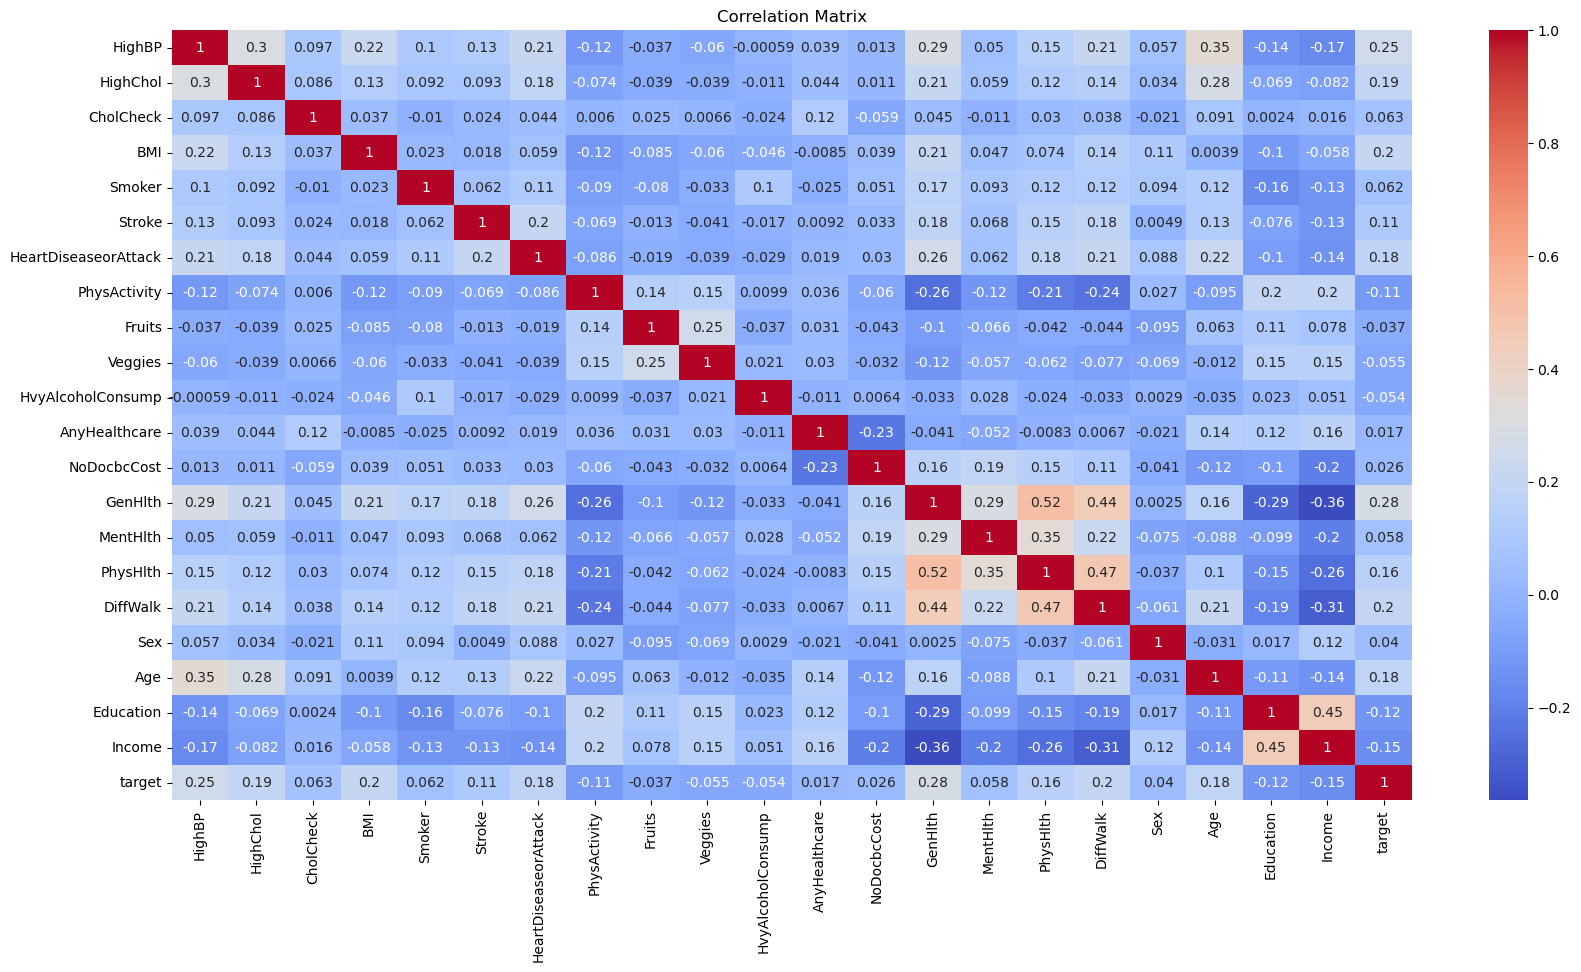

In [18]:
# Visualize correlations 
plt.figure(figsize=(20, 10))
sns.heatmap(dataFrame.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**Predictors exclusion**

From the processed data we can see some high correlations:
1. There is a high correlation of 45%, betweent Income and Education, so for this case we will remove the Income feature to reduce dependencies between tese variables.
2. There is high correlation of 52% between Physical Health and General Health, also checking the correlation between other variables, it is possible to identify that GenHealth has less correlation with other features in comparison to Physical health, so for this implementation we will remove physical health from the data.
3. There is a high correlation of 44% between, DiffWalk and GenHealth, also a high correlation between DiffWalk and PhysHlth. For this case and knowing that PhyHealth has removed, for this case GenHealth will be removed.

In [21]:
dataToProcess = dataFrame.drop(['Income', 'PhysHlth', 'GenHlth'], axis=1)

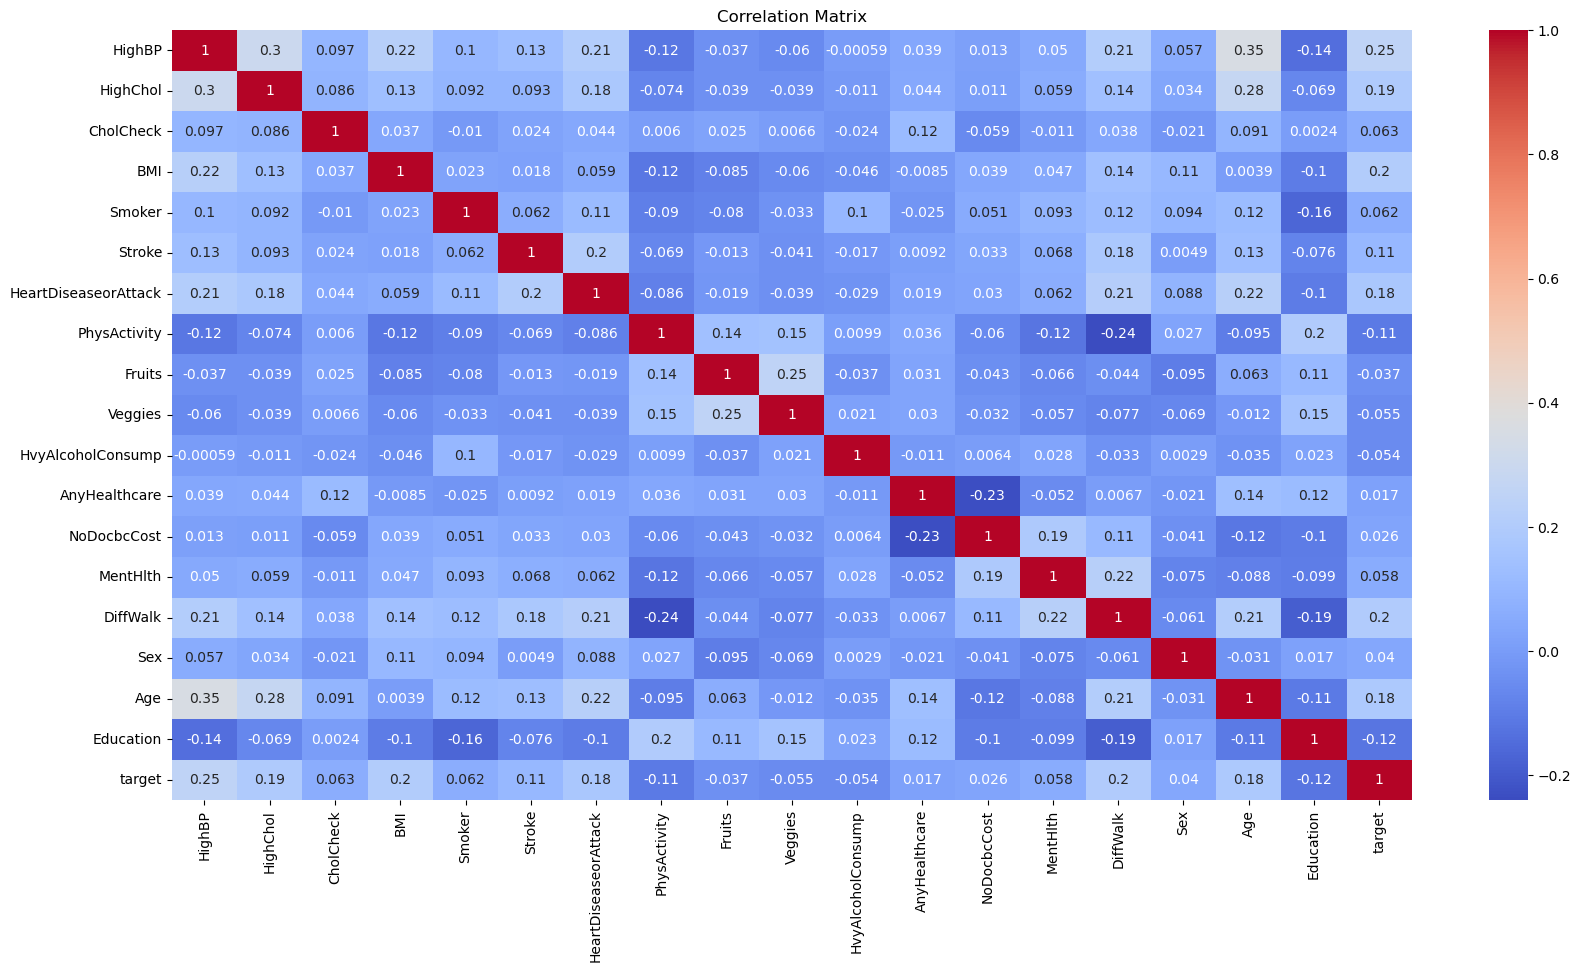

In [22]:
plt.figure(figsize=(20, 10))
sns.heatmap(dataToProcess.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**Removing nulls and Empty records**

In [37]:
print("Total number of records in the frame: ", dataToProcess.count())

Total number of records in the frame:  HighBP                  239916
HighChol                239916
CholCheck               239916
BMI                     239916
Smoker                  239916
Stroke                  239916
HeartDiseaseorAttack    239916
PhysActivity            239916
Fruits                  239916
Veggies                 239916
HvyAlcoholConsump       239916
AnyHealthcare           239916
NoDocbcCost             239916
MentHlth                239916
DiffWalk                239916
Sex                     239916
Age                     239916
Education               239916
target                  239916
dtype: int64


In [38]:
#number of null values per column
dataToProcess.isnull().sum()

HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
MentHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
target                  0
dtype: int64

In [39]:
#number of No value NaN per column
dataToProcess.isna().sum()

HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
MentHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
target                  0
dtype: int64

**Data Processing**

After processing and analyzing the data, I will folllow the next steps to start implementing a prediction model. The objective is to test three models to find the best response of each of this models. These are the steps that will be implemented:

1. Data Split:
   The data will be splited into Train data taking 70% of the records and Test data with 30% of the records.
2. Machine learning Model implementation:
   - Linear regression.
   - K-nearest neighboors.
   - Random forest.
   - Ridge regression.
   - Lasso regression.
   - Elastic Net regression
3. Cross validation and Hyperparameter tunning
4. Model validation and Final performance metrics.
5. Conclusion